In [5]:
ll /global/cscratch1/sd/dstn/dr9-cosmos-subs

total 40
drwxrwxr-x 9 dstn 4096 Feb 24  2021 80/
drwxrwxr-x 9 dstn 4096 Feb 24  2021 81/
drwxrwxr-x 9 dstn 4096 Feb 24  2021 82/
drwxrwxr-x 9 dstn 4096 Feb 24  2021 83/
drwxrwxr-x 9 dstn 4096 Feb 24  2021 84/
drwxrwxr-x 9 dstn 4096 Feb 24  2021 85/
drwxrwxr-x 9 dstn 4096 Feb 24  2021 86/
drwxrwxr-x 9 dstn 4096 Feb 24  2021 87/
drwxrwxr-x 9 dstn 4096 Feb 24  2021 88/
drwxrwxr-x 9 dstn 4096 Feb 24  2021 89/


In [6]:
ll /global/project/projectdirs/cosmo/work/legacysurvey/dr9.1.1/

total 38649
drwxrwsr-x+  9 landriau     4096 Jun  1 10:07 calib/
-rw-rw-r--+  1 dstn     12584409 Jun 23 10:37 ccds-annotated-decam-dr9.1.1-uncut.fits.gz
-rw-rw-r--+  1 dstn     12768689 Jun 23 10:37 ccds-annotated-decam-dr9.1.1.fits.gz
drwxrwsr-x+ 12 landriau     4096 Feb 19  2021 coadd/
lrwxrwxrwx   1 dstn           34 Jun 23 14:02 images -> /global/homes/d/dstn/cosmo/staging/
drwxrwsr-x+ 12 landriau     4096 Feb 19  2021 logs/
drwxrwsr-x+  3 landriau     4096 Dec 11  2020 logs-calibs/
drwxrwsr-x+ 12 landriau     4096 Feb 19  2021 metrics/
-rw-rw-r--+  1 dstn      2293134 Jun 23 10:37 survey-ccds-cosmos-deep-clip.fits.gz
-rw-rw-r--+  1 dstn     11891520 Jun 23 10:37 survey-ccds-decam-dr9.1.1.kd.fits
drwxrwsr-x+ 12 landriau     4096 Feb 19  2021 tractor/
drwxrwsr-x+ 12 landriau     4096 Feb 19  2021 tractor-i/
drwxrwsr-x+  3 landriau     4096 Dec 11  2020 zpts/


In [7]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from photometry import Catalogue, setup_logging, utils

output_dir = os.path.join(os.environ['CSCRATCH'],'legacysim','dr9','cosmos','merged')
deep_fn = os.path.join(output_dir,'deep.fits')
subs = range(80,90)
sub_fns = [os.path.join(output_dir,'sub_{:d}.fits'.format(isub)) for isub in subs]
dr9_fn = os.path.join(output_dir,'dr9.fits')

bands = ['g','r','z']
keep = ['ra','dec','brick_primary','brickname','maskbits']
keep += ['flux_{}'.format(b) for b in bands]
keep += ['fiberflux_{}'.format(b) for b in bands]
keep += ['type','sersic','shape_r','shape_e1','shape_e2']
keep += ['galdepth_{}'.format(b) for b in bands]
keep += ['mw_transmission_{}'.format(b) for b in bands]
keep += ['ebv']

todo = []

def get_catalog(fn):
    catalog = Catalogue.load_fits(fn,keep=keep)
    return catalog[catalog['brick_primary']]

In [8]:
if 'deep' in todo:
    base_dir = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9.1.1/tractor/'
    fns = glob.glob(os.path.join(base_dir,'*','tractor-*.fits'))
    catalog = 0
    setup_logging('warning')
    for ifn,fn in enumerate(fns):
        #if ifn % (len(fns)//20) == 0: print('{}/{}'.format(ifn,len(fns)))
        catalog += get_catalog(fn)

    catalog.save_fits(deep_fn)

In [9]:
if 'subs' in todo:
    base_dir = '/global/cscratch1/sd/dstn/dr9-cosmos-subs/'
    for isub,sub_fn in zip(subs,sub_fns):
        fns = glob.glob(os.path.join(base_dir,'{}'.format(isub),'tractor','*','tractor-*.fits'))
        catalog = 0
        for ifn,fn in enumerate(fns): catalog += get_catalog(fn)
        catalog.save_fits(sub_fn)

In [10]:
if 'dr9' in todo:
    base_dir = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south/tractor'
    bricknames = np.unique(Catalogue.load_fits(deep_fn,keep=['brickname'])['brickname'])
    catalog = 0
    for brickname in bricknames:
        fn = os.path.join(base_dir,brickname[:3],'tractor-{}.fits'.format(brickname))
        catalog += get_catalog(fn)
    catalog.save_fits(dr9_fn)

In [11]:
def get_maskbit(catalog, bits=[1, 5, 6, 7, 11, 12, 13]):
    mask = catalog.trues()
    for bit in bits:
        mask &= (catalog['maskbits'] & 2**bit) == 0
    return mask

def get_mask_depth(catalog, threshold=(5000.,2000.,500.)):
    #return np.all([catalog['brick_galdepth_{}'.format(b)] > t for (b,t) in zip(bands,threshold)],axis=0)
    return np.all([catalog['galdepth_{}'.format(b)] > t for (b,t) in zip(bands,threshold)],axis=0)

from preprocess import isELG_colors
def get_mask_ts(catalog, **kwargs):
    return isELG_colors(**{'%sflux' % b:utils.mag_to_flux(catalog[b]) for b in ['g','r','z','gfiber']},**kwargs)[1]

def fill_catalog(catalog):
    for b in bands:
        catalog['brick_galdepth_{}'.format(b)] = utils.digitized_statistics(catalog['brickname'],values=catalog['galdepth_{}'.format(b)],statistic='median')
        catalog[b] = utils.flux_to_mag(catalog['flux_{}'.format(b)]/catalog['mw_transmission_{}'.format(b)])
        catalog['{}fiber'.format(b)] = utils.flux_to_mag(catalog['fiberflux_{}'.format(b)]/catalog['mw_transmission_{}'.format(b)])
    catalog['shape_ba'],catalog['shape_phi'] = utils.get_shape_ba_phi(catalog['shape_e1'],catalog['shape_e2'])
    return catalog

In [12]:
subs = sum([Catalogue.load_fits(sub_fn) for sub_fn in sub_fns])
deep = Catalogue.load_fits(deep_fn)
dr9 = Catalogue.load_fits(dr9_fn)

catalogs = {'subs':subs,'deep':deep,'dr9':dr9}
for catalog in catalogs.values():
    fill_catalog(catalog)

bricksubs = np.unique(subs['brickname'])
with open('bricklist_south.txt','w') as file:
    for brickname in bricksubs:
        file.write('{}\n'.format(brickname))

/global/u2/a/adematti/lib/photometry/photometry/utils/utils.py:21: RuntimeWarning: divide by zero encountered in log10
  return -2.5*(np.log10(x)-9.)
/global/u2/a/adematti/lib/photometry/photometry/utils/utils.py:21: RuntimeWarning: invalid value encountered in log10
  return -2.5*(np.log10(x)-9.)


In [13]:
for t in np.unique(deep['type']):
    mask = deep['type'] == t
    print('For type {} sersic is {}'.format(t,np.unique(deep['sersic'][mask])))

For type DEV sersic is [4.]
For type DUP sersic is [0.]
For type EXP sersic is [1.]
For type PSF sersic is [0.]
For type REX sersic is [1.]
For type SER sersic is [0.5        0.50001025 0.50001776 ... 5.999596   5.9996924  6.        ]


1.0435838e-05 6.2831492
subs kstest for phi: KstestResult(statistic=0.005650718862560078, pvalue=0.02369829032075481)
0.0 6.2831855
deep kstest for phi: KstestResult(statistic=0.0037237135494526674, pvalue=1.038740991802744e-12)
6.4530883e-07 6.2831845
dr9 kstest for phi: KstestResult(statistic=0.004195718967317186, pvalue=6.943642050119378e-09)


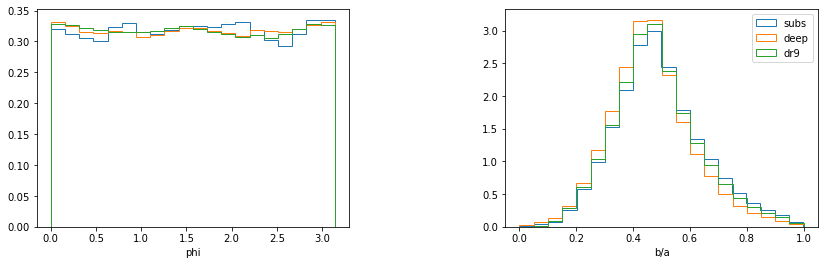

In [14]:
from scipy import stats
fig,lax = plt.subplots(ncols=2,nrows=1,sharex=False,sharey=False,figsize=(14,4),squeeze=False)
fig.subplots_adjust(hspace=0.4,wspace=0.5)
lax = lax.flatten()
bins = np.linspace(0,np.pi)

for name,catalog in catalogs.items():
    mask = (catalog['sersic'] > 0) & (catalog['type'] != 'REX') # REX: round by definition
    ba,phi = catalog['shape_ba'][mask],catalog['shape_phi'][mask]
    print(phi.min(),phi.max())
    lax[0].hist(phi % np.pi,density=True,histtype='step',bins=20,label=name)
    lax[1].hist(ba,density=True,histtype='step',bins=20,label=name)
    phi = (phi % np.pi)/np.pi
    print(name,'kstest for phi:',stats.kstest(phi,'uniform'))
lax[0].set_xlabel('phi')
lax[1].set_xlabel('b/a')
lax[1].legend()

In [16]:
depths = {}
bricknames = np.unique(deep['brickname'])
for name,catalog in catalogs.items():
    depths[name] = {}
    for b in bands:
        values = catalog['brick_galdepth_{}'.format(b)]
        depths[name][b] = utils.digitized_interp(bricknames,catalog['brickname'],catalog['brick_galdepth_{}'.format(b)],np.nan)

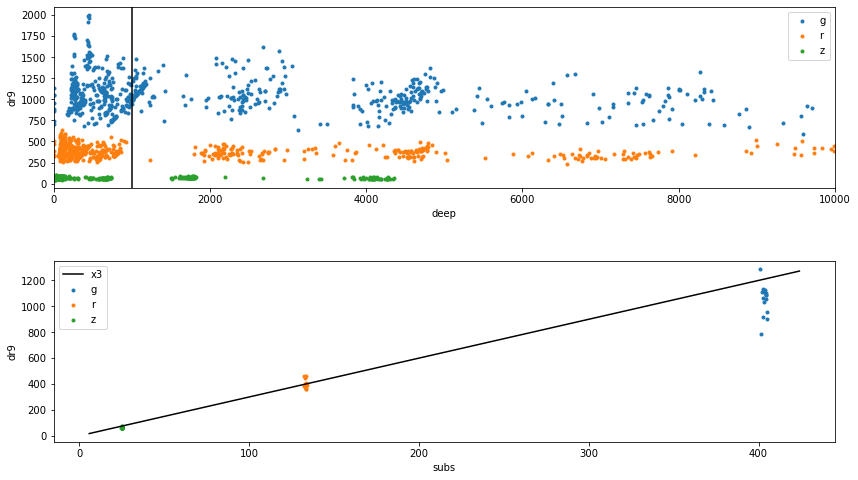

In [17]:
fig,lax = plt.subplots(ncols=1,nrows=2,sharex=False,sharey=False,figsize=(14,8),squeeze=False)
fig.subplots_adjust(hspace=0.4,wspace=0.5)
lax = lax.flatten()
for b in bands:
    lax[0].scatter(depths['deep'][b],depths['dr9'][b],marker='.',label=b)
lax[0].axvline(1000.,ymin=0.,ymax=1.,color='k')
lax[0].set_xlabel('deep')
lax[0].set_xlim(0.,10000)
lax[0].set_ylabel('dr9')
lax[0].legend()

for b in bands:
    lax[1].scatter(depths['subs'][b],depths['dr9'][b],marker='.',label=b)
x = np.linspace(*lax[1].get_xlim(),num=1000)
lax[1].plot(x,x*3.,color='k',label='x3')
lax[1].set_xlabel('subs')
lax[1].set_ylabel('dr9')
lax[1].legend()

/global/u2/a/adematti/lib/photometry/photometry/utils/utils.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return 5./np.sqrt(x)


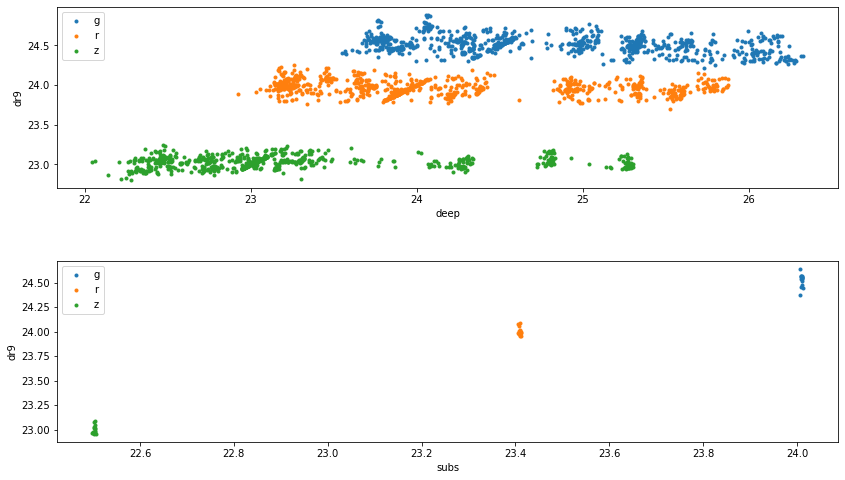

In [18]:
fig,lax = plt.subplots(ncols=1,nrows=2,sharex=False,sharey=False,figsize=(14,8),squeeze=False)
fig.subplots_adjust(hspace=0.4,wspace=0.5)
lax = lax.flatten()
for b in bands:
    lax[0].scatter(utils.depth_to_mag(depths['deep'][b]),utils.depth_to_mag(depths['dr9'][b]),marker='.',label=b)
lax[0].set_xlabel('deep')
lax[0].set_ylabel('dr9')
lax[0].legend()

for b in bands:
    lax[1].scatter(utils.depth_to_mag(depths['subs'][b]),utils.depth_to_mag(depths['dr9'][b]),marker='.',label=b)
lax[1].set_xlabel('subs')
lax[1].set_ylabel('dr9')
lax[1].legend()

In [13]:
thresholds = [(4000.,2000.,500.),(6000.,1600.,300.)]

for threshold in thresholds:
    ibricks = np.all([depths['deep'][b] > t for (b,t) in zip(bands,threshold)],axis=0)
    mask = np.isin(deep['brickname'],bricknames[ibricks])
    mask = get_mask_depth(deep,threshold=threshold)
    mask &= get_maskbit(deep)
    n = mask.sum()
    print('There are {:d}/{:d} bricks {:d} ({:.4f}%) sources with depth > {}'.format(ibricks.sum(),ibricks.size,n,n*100./deep.size,threshold))
    print('Min depth are {}'.format([depths['deep'][b][ibricks].min() for b in bands]))

There are 100/811 bricks 1560854 (24.1471%) sources with depth > (4000.0, 2000.0, 500.0)
Min depth are [4079.98486328125, 2665.53076171875, 578.1759033203125]
There are 49/811 bricks 921164 (14.2508%) sources with depth > (6000.0, 1600.0, 300.0)
Min depth are [6472.162109375, 6116.61376953125, 1649.969970703125]


In [14]:
prev_fn = '/project/projectdirs/desi/users/ajross/MCdata/seed.fits'
prev = Catalogue.load_fits(prev_fn)
print('Previous thruth catalog has {:d} sources'.format(prev.size))
for b in bands:
    print(b,prev['galdepth_{}'.format(b)].min(),prev['galdepth_{}'.format(b)].max())

Previous thruth catalog has 549181 sources
g 4000.085 17463.467
r 2000.0415 9908.52
z 500.0376 1949.8811


In [15]:
brick_fn = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south/survey-bricks-dr9-south.fits.gz'
catalogbricks = Catalogue.load_fits(brick_fn)
for b in bands:
    depth = catalogbricks['galdepth_{}'.format(b)]
    depth = utils.mag_to_depth(depth)
    print(b,depth.min(),depth.max(),np.median(depth))

g 2.5e-17 7026.749 1255.6226
r 2.5e-17 3386.5603 408.82043
z 2.5e-17 414.76126 74.762405


In [26]:
mask = get_mask_depth(deep) & get_maskbit(deep) & get_mask_ts(deep)
print('Number of true ELGs: {:d}'.format(mask.sum()))

prev['gfiber'] = prev['g']
mask_old = get_mask_ts(prev)
print('Number of true ELGs in old sample: {:d}'.format(mask_old.sum()))
print(np.sum(get_mask_depth(deep) & get_maskbit(deep)),prev.size)

Number of true ELGs: 11435
Number of true ELGs in old sample: 17747
1560854 549181


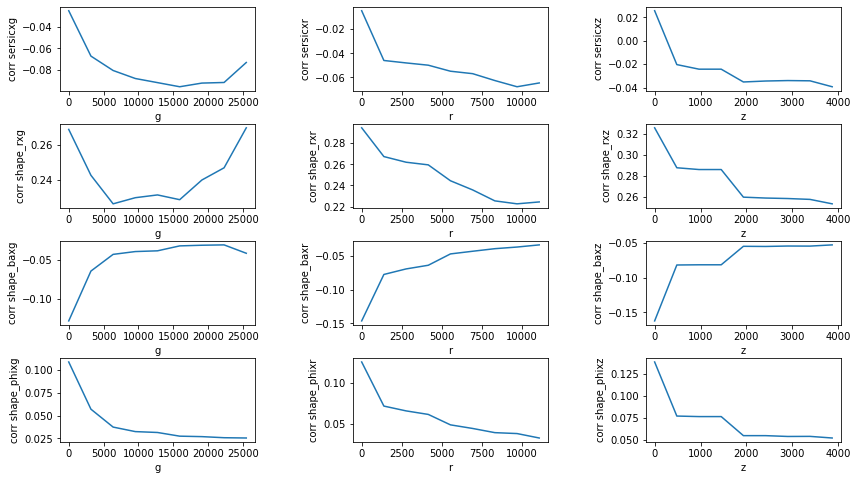

In [17]:
fields = ['sersic','shape_r','shape_ba','shape_phi']
fig,llax = plt.subplots(ncols=3,nrows=len(fields),sharex=False,sharey=False,figsize=(14,8),squeeze=False)
fig.subplots_adjust(hspace=0.4,wspace=0.5)

mask_ts = get_maskbit(deep) & get_mask_ts(deep,gmarg=0.5,grmarg=0.5,rzmarg=0.5)
deep_ts = deep[mask_ts]

for lax,field in zip(llax,fields):
    for ax,b in zip(lax,bands):
        mask = deep_ts.trues()
        thresholds = np.linspace(depths['deep'][b].min(),depths['deep'][b].max(),10)[:-1]
        corrs = []
        for threshold in thresholds:
            t = [0.,0.,0.]
            t[bands.index(b)] = threshold
            mask &= get_mask_depth(deep_ts,threshold=t)
            corrs.append(np.corrcoef(deep_ts[field][mask],deep_ts['flux_{}'.format(b)][mask])[0,1])
        ax.plot(thresholds,corrs)
        ax.set_xlabel(b)
        ax.set_ylabel('corr {}x{}'.format(field,b))

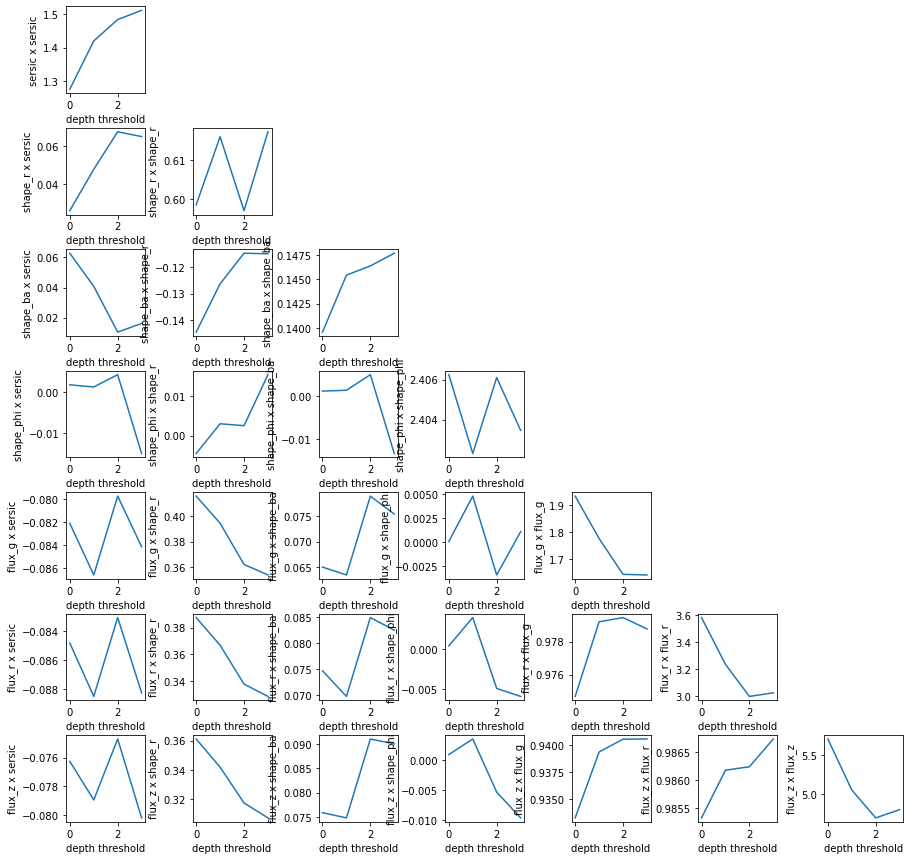

In [18]:
fields = ['sersic','shape_r','shape_ba','shape_phi'] + ['flux_{}'.format(b) for b in bands]

fig,llax = plt.subplots(ncols=len(fields),nrows=len(fields),sharex=False,sharey=False,figsize=(15,15),squeeze=False)
fig.subplots_adjust(hspace=0.4,wspace=0.6)

mask_ts = get_maskbit(deep) & get_mask_ts(deep,gmarg=0.5,grmarg=0.5,rzmarg=0.5)
mask_ts &= (deep['sersic'] > 0) & (deep['type'] != 'REX')
deep_ts = deep[mask_ts]

thresholds = [np.linspace(depths['deep'][b].min(),depths['deep'][b].max(),10) for b in bands]
masks = []
for threshold in zip(*thresholds):
    mask = get_mask_depth(deep_ts,threshold=threshold)
    if mask.any(): masks.append(mask)

for ii,ifield in enumerate(fields):
    for jj,jfield in enumerate(fields):
        ax = llax[ii][jj]
        if jj > ii:
            ax.set_axis_off()
            continue
        corrs = []
        for mask in masks:
            if ii == jj:
                corrs.append(np.std(deep_ts[ifield][mask]))
            else:
                corrs.append(np.corrcoef(deep_ts[ifield][mask],deep_ts[jfield][mask])[0,1])
        ax.plot(np.arange(len(corrs)),corrs)
        ax.set_xlabel('depth threshold')
        ax.set_ylabel('{} x {}'.format(ifield,jfield))

In [19]:
catalog = Catalogue.load_fits(deep_fn)
rng = np.random.RandomState(seed=42)
fill_catalog(catalog)
catalog['shape_phi'] = rng.uniform(0.,np.pi,catalog.size)
truth_fn = os.path.join(os.getenv('HOME'),'photometry','truth_cosmos_deep.fits')
catalog.save(truth_fn)

/global/homes/a/adematti/lib/photometry/utils/utils.py:21: RuntimeWarning: divide by zero encountered in log10
  return -2.5*(np.log10(x)-9.)
/global/homes/a/adematti/lib/photometry/utils/utils.py:21: RuntimeWarning: invalid value encountered in log10
  return -2.5*(np.log10(x)-9.)


In [20]:
ll /global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/

Release master is already installed in /global/homes/a/adematti/.local/share/jupyter/kernels/desi-master, aborting.
total 705
drwxrws---  5 shadaba   4096 May 26 05:20 Target4Ang/
drwxrws---  3 ajross  131072 Jun  2 07:22 test/
drwxrws--- 16 shadaba  16384 May 28 00:23 test_Shadab/
drwxrws--- 27 shadaba  16384 May 27 12:23 test_Shadab_tmp/
drwxrws---  3 ajross   65536 May 28 01:57 v0/
drwxrws---  2 ajross  131072 May 24 11:13 v0.1/


In [21]:
data_full = Catalogue.load('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/v0/ELG_HIPAlltiles_full.dat.fits')

In [22]:
bricknames = np.unique(data_full['BRICKNAME'])
print('Found {:d} bricks in LSS catalogs'.format(bricknames.size))
bricksubs = np.unique(subs['brickname'])
print('In cosmos sub {:d} / in LSS {:d}'.format(np.isin(bricksubs,bricknames).sum(),len(bricksubs)))

2705
16 16


Text(0, 0.5, '$r-z$')

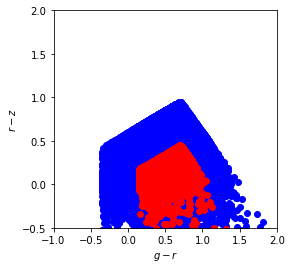

In [23]:
truth = Catalogue.load_fits(truth_fn)
mask = get_maskbit(truth) & get_mask_depth(truth)
mask &= get_mask_ts(truth,gmarg=0.5,grmarg=0.5,rzmarg=0.5)
truth = truth[mask]
mask = get_mask_ts(truth,gmarg=0.,grmarg=0.,rzmarg=0.)

fig,ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(4,4))
ax.scatter(truth['r'] - truth['z'],truth['g'] - truth['r'],color='b')
ax.scatter(truth['r'][mask] - truth['z'][mask],truth['g'][mask] - truth['r'][mask],color='r')
ax.set_xlim(-1.,2.)
ax.set_ylim(-0.5,2.)
ax.set_xlabel('$g-r$')
ax.set_ylabel('$r-z$')

In [24]:
print(mask.sum())
fn = os.path.join(output_dir,'truth_ELG_HIP.fits')
truth[mask].save_fits(fn)

11435


In [68]:
mask_deep = get_mask_depth(deep) & get_maskbit(deep)
mask_prev = prev.trues()
for b in bands:
    tmp = np.isfinite(deep[b])
    print('deep',b,tmp.sum()/tmp.size)
    mask_deep &= tmp
    tmp = np.isfinite(prev[b])
    print('prev',b,tmp.sum()/tmp.size)
    mask_prev &= tmp

deep g 0.9742702928822393
prev g 0.984504198069489
deep r 0.9810926141051364
prev r 0.9982391961848643
deep z 0.9618634424975893
prev z 0.9964073775312693


std deep v.s. prev 1.4604317 1.3157303
std deep v.s. prev 1.4139205 1.3079617
std deep v.s. prev 1.5814341 1.4823291


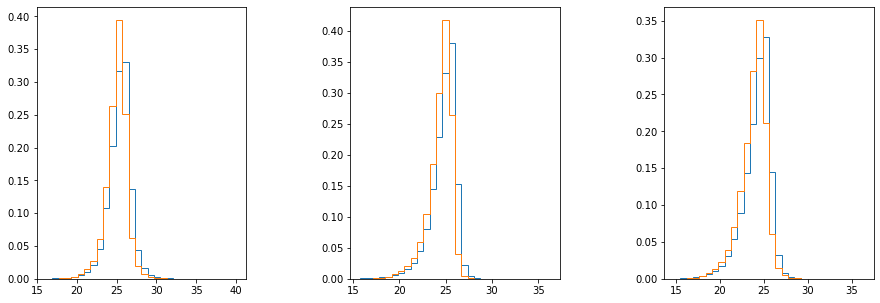

In [70]:
fig,lax = plt.subplots(ncols=len(bands),nrows=1,sharex=False,sharey=False,figsize=(15,5),squeeze=False)
fig.subplots_adjust(hspace=0.4,wspace=0.5)
lax = lax.flatten()

for ax,band in zip(lax,bands):
    bins = ax.hist(deep[band][mask_deep],histtype='step',density=True,bins=30)[1]
    ax.hist(prev[band][mask_prev],histtype='step',density=True,bins=bins)
    print('std deep v.s. prev',np.std(deep[band][mask_deep]),np.std(prev[band][mask_prev]))

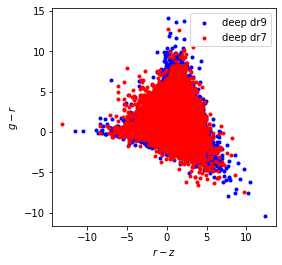

In [71]:
fig,ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(4,4))
ax.scatter(deep['r'][mask_deep] - deep['z'][mask_deep],deep['g'][mask_deep] - deep['r'][mask_deep],color='b',marker='.',label='deep dr9')
ax.scatter(prev['r'][mask_prev] - prev['z'][mask_prev],prev['g'][mask_prev] - prev['r'][mask_prev],color='r',marker='.',label='deep dr7')
ax.set_xlabel('$r-z$')
ax.set_ylabel('$g-r$')
ax.legend()
#utils.savefig('color_diagram.png')

g 8026.0137 7920.144
r 10498.84 5062.4727
z 4058.7983 964.5958


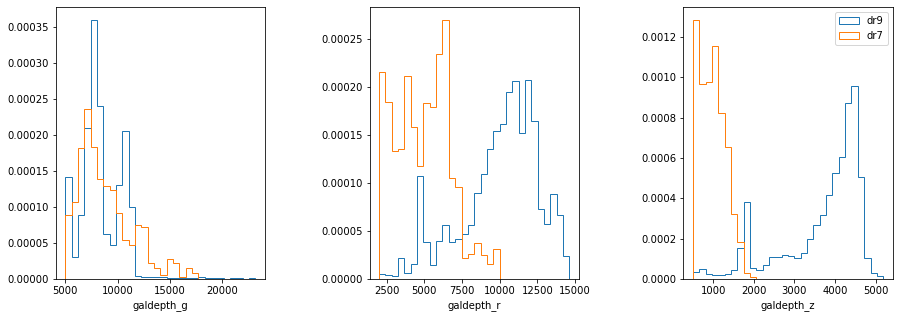

In [69]:
fig,lax = plt.subplots(ncols=len(bands),nrows=1,sharex=False,sharey=False,figsize=(15,5),squeeze=False)
fig.subplots_adjust(hspace=0.4,wspace=0.5)
lax = lax.flatten()

for ax,band in zip(lax,bands):
    bins = ax.hist(deep['galdepth_{}'.format(band)][mask_deep],histtype='step',density=True,bins=30,label='dr9')[1]
    ax.hist(prev['galdepth_{}'.format(band)][mask_prev],histtype='step',density=True,bins=bins,label='dr7')
    ax.set_xlabel('galdepth_{}'.format(band))
    print(band,np.median(deep['galdepth_{}'.format(band)][mask_deep]),np.median(prev['galdepth_{}'.format(band)][mask_prev]))
ax.legend()